# まとめ
- 木探索アルゴリズムによって，着手を進めていった時に最善な手を発見できる  
  
  
- ミニマックス木探索は，最適手を打つ2人のプレイヤーを入れ替えて探索する
    - 複雑なゲームでは時間がかかりすぎるので，木を小さくする必要がある
        
  
- 局面評価関数の結果がプレイヤーにとって悪ければそれ以上探索しない
    - 本章では取り急ぎ盤上の石の個数の比率とした
    - これにより，深さの枝刈りができる
  
  
- αβ法で，自分の手によって相手が大きく有利になるような手があるなら中断
    - α，βに各プレイヤーの最高手を保持しながら探索することから
    - これにより，幅の枝刈りができる
  
  
- モンテカルロ木探索ではランダムにゲームをシミュレートした統計情報を利用
    - ランダムに手を選び，その結果どのプレイヤーが勝つかを記録していく
    - 枝を伸ばしてシミュレートを行うことをロールアウトと呼ぶ
    - upper confidense bound for tree(UCT)スコアに基づき枝を伸ばす
        - ノードの勝率の高さと訪問していないノードの多さのトレードオフ
  
  
- その他実装テクニック
    - 短時間に多くのロールアウトができた方が強くなるので，最適化は大事
    - ロールアウト中に良い手を選ぶロールアウトポリシーは重すぎないよう
    - 手を選択する過程で勝率が出るので，これが低いとき投了させると良い

- ミニマックスアルゴリズムで最善の手を見つける
- ミニマックス木探索を枝刈りによってスピードアップ
- モンテカルロ木探索

木探索: 多くの可能な一連の決定から，最良の結果につながるものを見つける  
ミニマックス: 各手番で視点を交代し，最適な手順を見つける．遅い．  
枝刈り: 最適でないとわかっている木の枝の部分を除外して高速化  
モンテカルロ木探索(MCTS): ドメイン固有の知識を使わず，確率的に探索

## ゲームの分類
- 確定: ゲームの経過がプレイヤーの決定にのみ依存
- 不確定: サイコロやカードのシャッフルのようなランダム要素がある
- 完全情報: 両方のプレイヤーがいつでも全てのゲーム状態を見ることができる
- 不完全情報: 他のプレイヤーの手札が何かわからない，など，ゲームの一部しか見えない

囲碁やチェスは完全確定情報ゲームに分類される  
各手番には，理論的に最適な手が一つあり，最初の手で全てが計画できると言える  
しかし，一般に膨大な選択肢があるため，計算機でも計算しきれない 


## ミニマックス探索による相手の手の予測
ミニマックス法： 自分がスコアを最大化しようとすると，相手はそれを最小化しようとしてくる，ということを仮定して戦略を立てていくアルゴリズム  

まずは簡単なところからいく．即座にゲームに勝つ手があるならそれを選ぶ  

In [1]:
# ゲームに勝つ手を選ぶ一般的なコード
def find_winning_move(game_state, next_player):
    
    # 考えうる全ての手の中で，それを打ったら勝利する手を返す
    for candidate_move in game_state.legal_moves(next_player):
        next_state = game_state.apply_move(candidate_move)
        if next_state.is_over() and next_state.winner == next_player:
            return candidate_move
    
    # 一手では勝てない
    return None

この関数は，仮想の局面を展開することで探索を行なっている．  
この展開した構造をゲーム木と呼ぶ  

さらに，次のターンで相手が勝ってしまうような手を選んではいけない．

In [3]:
# ゲームに負けない手を選ぶ一般的なコード
def eliminate_losing_moves(game_state, next_player):
    
    # 考えうる全ての手の中で，それを打った次の手で相手が勝たない手を選んで返す
    opponent = next_player.other()
    possible_moves = []
    for candidate_move in game_state.legal_moves(next_player):
        next_state = game_state.apply_move(candidate_move)
    
        # 次の相手の手番で勝利する手を探索
        opponent_winning_move = find_winning_move(next_state, opponent)
        
        # 負けないならその手は大丈夫
        if opponent_winning_move is None:
            possible_moves.append(candidate_move)
    
    # 負けない手の一覧
    return possible_moves

相手もまた，ゲームに負けない手を選んでくる．  
しかし，ゲームに勝てる手を1ターンで2つ用意できれば，勝てる．  
このように，相手が勝つ手を防げないような，勝ちにつながる手を探す．

In [4]:
# 相手が負けない手を選べないような手を選ぶ，一般的なコード
def find_two_step_win(game_state, next_player):
    
    opponent, next_player.other()
    for candidate_move in game_state.legal_moves(next_player):
        next_state = game_state.apply_move(candidate_move)
        
        # 相手にとって，負けない手が見つからないような手があれば，それを返す
        good_responses = eliminate_losing_moves(next_state, opponent)
        if not good_responses:
            return candidate_move
    
    # 相手はこちらの勝利を防ぐことができる
    return None

これまで紹介してきた3つの関数は，どれも同じような構造を持っている．  
全ての有効な手をループし，その手をとった後に得られる仮想的な局面を調べ，さらに相手がその手に最善の応答をしてくることを仮定．．．を繰り返している．

## 三目並べを解く:ミニマックスの例
三目並べの完全な手を選択するための戦略を一般化  
まずはゲームの結果を表す列挙型を定義する

In [1]:
import enum

class GameResult(enum.Enum):
    loss = 1
    draw = 2
    win = 3

def reverse_game_result(result):
    if result == GameResult.loss:
        return GameResult.win
    if result == GameResult.win:
        return GameResult.loss
    return result

あるプレイヤーがある状態から達成できる最高の勝敗を返す関数best_resultを実装 

In [2]:
def best_result(game_state):
    
    # 勝敗が付いている場合，自分の勝敗結果を返す(再帰の最後)
    if game_state.is_over():
        if game_state.winner() == game_state.next_player:
            return GameResult.win
        elif game_state.winner() is None:
            return GameResult.draw
        else:
            return GameResult.loss
    
    best_result_so_far = GameResult.loss
    opponent = game_state.next_player.other

    # 全てのありうる手で，最も自分にとって良い結果を返す
    for candidate_move in game_state.legal_moves():
        
        # 自分が手を打った後，
        next_state = game_state.apply_move(candidate_move)
        
        # 相手の最善結果を予測
        opponent_best_result = best_result(next_state)
        
        # 相手の最善結果の逆が，その手による我々の結果になる
        our_result = reverse_game_result(opponent_best_result)
        
        # この手がより良い結果に結びつくならば，それをここまでの最善結果とする
        if our_result.value > best_result_so_far.value:
            best_result_so_far = our_result
    
    return best_result_so_far

 可能な全ての手をループし，best_resultを呼び出すことで，最良の手を選択するエージェントを実装して見る

In [3]:
from dlgo.agent.base import Agent
import random

class MinimaxAgent(Agent):
    
    # 最善の手順を返す
    def select_move(self, game_state):
        winning_moves = []
        draw_moves = []
        losing_moves = []
        
        # 全てのありうる手を，最善の結果ごとに記録していく
        for possible_move in game_state.legal_moves():
            next_state = game_state.apply_move(possible_move)
            
            # その手を打った時，相手の最善の結果の逆が自分の結果になる
            opponent_best_outcome = best_result(next_state)
            our_best_outcome = reverse_game_result(opponent_best_outcome)
            
            # 相手が最善の手を尽くしても自分が勝つような手を欲する
            if our_best_outcome == GameResult.win:
                winning_moves.append(possible_move)
            elif our_best_outcome == GameResult.draw:
                draw_moves.append(possible_move)
            else:
                losing_moves.append(possible_move)
        
        # 記録した手から最善の手を選んで返す
        if winning_moves:
            return random.choice(winning_moves)
        if draw_moves:
            return random.choice(draw_moves)
        return random.choice(losing_moves)

三目並べの完全なコードは以下  
https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/dlgo/ttt  

tttboard.py: 三目並べ用の盤のルール実装  
ttttypes.py: 三目並べに使うPlayerとPoint型の定義

このミニマックスアルゴリズムを，三目並べのような単純なゲームに適用すると，無敵になることがわかる．  
しかし，このアルゴリズムをチェスや囲碁などに適用すると，あまりにも遅い．

In [4]:
from dlgo.ttt.tttboard import GameState, Move
from dlgo.ttt.ttttypes import Player
from dlgo.ttt.tttutils import print_move, print_board, point_from_coords
from IPython.display import clear_output

def ttt_human_v_minimax(first=Player.x):
    game = GameState.new_game(first=first)
    bot = MinimaxAgent()
    
    print_board(game.board)
    while not game.is_over():
        if game.next_player == Player.x:
            human_move = input('-- ')
            point = point_from_coords(human_move.strip())
            move = Move(point)
        else:
            move = bot.select_move(game)
            
        clear_output()
        
        print_move(game.next_player, move)
        game = game.apply_move(move)
        
        print_board(game.board)

    print("GAME OVER!, Winner: ", game.winner())

In [5]:
ttt_human_v_minimax(first=Player.x)

Player.o A3
 3 oxo
 2 oxx
 1 xoo
    ABC
GAME OVER!, Winner:  None


## 枝刈りによる探索空間の削減
三目並べですら，初手の選択には多くの時間を要する．  
チェスと囲碁では，宇宙の原子の数よりも局面数が多い．  
これを高速化するために，ゲーム木の一部を削減する戦略である枝刈りを行う  

木の幅W： 指定された局面での可能な手の数  
木の深さd: 最終的なゲーム状態までの手数  
ゲームの局面数は$W^d$で近似的に求められる．  

例えば，10ターンまであり，選択肢が10のゲームは$10^{10}=100$億の局面がある  
この各ターンの選択肢を8に減らし，さらに9手のみを調べるようにすれば，  
局面数は$8^9=$1億3千万となり，98%以上を削減できる．

### 局面評価による探索の深さの削減  
局面評価関数: 誰がどのくらい優勢かの感覚を模倣する関数  
チェスでは駒に点数をつけることで簡単に評価をつけられる  
囲碁では石をとることよりも，取れる状況にする方が重要なので，実装が難しい  
しかし，どれだけ石を持っているかを評価するのは，ランダムよりはマシ

一定数先の手を予測し，そのときどれだけ石を持っているかを評価  
その中から，最も良い評価(持っている石の数)に結びつく手を選ぶ

In [ ]:
# そのときの盤面評価を，石の数の差で行う単純な局面評価関数
def capture_diff(game_state):
    black_stones = 0
    white_stones = 0
    
    # 盤面上をトレースして石があったらカウント
    for r in range(1, game_state.board.num_rows + 1):
        for c in range(1, game_state.board.num_cols + 1):
            p = gotypes.Point(r, c)
            color = game_state.board.get(p)
            if color == gotypes.Player.black:
                black_stones += 1
            elif color == gotypes.Player.white:
                white_stones += 1
                
    # 両者の石の個数の差をとる
    diff = black_stones - white_stones
    
    # 黒の手番の場合，黒にとっての評価を返す
    if game_state.next_player == gotypes.Player.black:
        return diff
    
    # 白の手番の場合，白にとっての評価，すなわち差にマイナスをつけたものを返す
    return -1 * diff

上記のcapture_diffを，例えば2手先までapply_moveして探索すれば良い．  
これで，2手先に石が取られないようにする，といった戦略が可能  
このcapture_diffを用いて，深さを制限するようなbest_resultを実装する  

In [ ]:
# 局面評価関数を用いることで深さを制限した，最も良い手の評価を得る関数
def best_result(game_state, max_depth, eval_fn):

    if game_state.is_over():
        if game_state.winner() == game_state.next_player:
            return MAX_SCORE # 勝利できる手ならば是非選ぶべき
        else:
            return MIN_SCORE # 敗北が決定する手ならば絶対選ばないべき
    
    # 再帰止め: この時点でのスコアを返す
    if max_depth == 0:
        return eval_fn(game_state)
    
    best_so_far = MIN_SCORE
    
    # 全てのありうる手の中から，
    for candidate_move in game_state.legal_moves():
        next_state = game_state.apply_move(candidate_move)
        
        # minimaxで相手の最善手を読み，
        opponent_best_result = best_result(next_state, max_depth - 1, eval_fn)
        
        # こちらにとって，最も悪くない結果を保持していく
        our_result = -1 * opponent_best_result
        if our_result > best_so_far:
            best_so_far = our_result
    
    # ありうる手の中で，最高のスコアを返す
    return best_so_far

### αβ法による探索幅の削減
例えば，相手が石を4つ取れるようになってしまうような手は選びたくない．  
このように一つの強力な応手が見つかるとすぐに別の手を探すのがαβ法のアイデア  

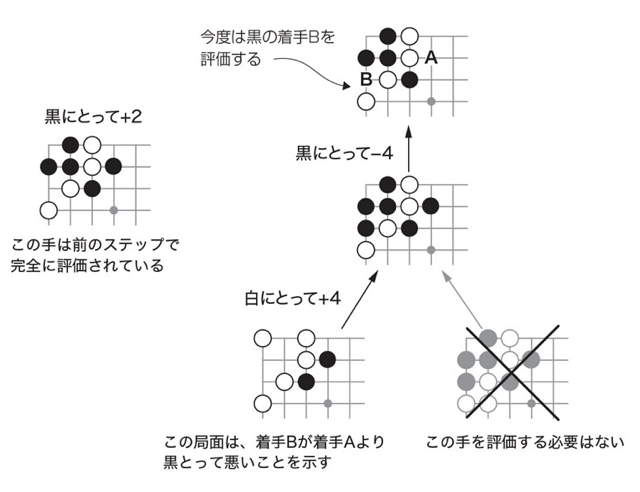

具体的には，このように，+2の評価があるのに，-4の評価が別の手で発見されたら，白は少なくともそっちを選んでくるので，この枝をこれ以上探索する必要はない

実装では，各プレイヤーにとっての最善の結果を追跡する．  
この最善の結果は，それぞれα，βと伝統的には呼ばれている  

In [ ]:
# αβ法による最高の局面評価値の取得
# 局面評価関数によるbest_resultを拡張するように実装できる 
# 全てのありうる手をループするが，自分にとって最高スコアが悪化するならそこで中断
def alpha_beta_result(game_state, max_depth, best_black, best_white, eval_fn):
    
    # 勝てるなら最高スコア，負けるなら最低スコアを返す
    if game_state.is_over():
        if game_state.winner() == game_state.next_player:
            return MAX_SCORE
        else:
            return MIN_SCORE
    
    # 再帰止め: その時点での評価を返す
    if max_depth == 0:
        return eval_fn(game_state)
    
    best_so_far = MIN_SCORE
    
    # 全てのありうる手の中から，
    for candidate_move in game_state.legal_moves():
        next_state = game_state.apply_move(candidate_move)
        
        # minimax + alphabetaで相手の最善手を読み，
        opponent_best_result = alpha_beta_result(
            next_state, max_depth-1,
            best_black, best_white, eval_fn
        )
        
        # その場合の我々のスコアを得て，最高なら更新
        our_result = -1 * opponent_best_result
        if our_result > best_so_far:
            best_so_far = our_result
        
        # ここからがαβ
        
        # これから打とうとしているのが白の時
        if game_state.next_player == Player.white:
            
            # best_so_farは白にとってのスコアなので，best_whiteの更新を行う
            if best_so_far > best_white:
                best_white = best_so_far
            
            # そのときの黒にとってのスコアは，白のスコアのマイナス
            outcome_for_black = -1 * best_so_far
            
            # その手がこれまでの黒の最高手よりも悪手なら，ここでこの枝の幅探索を終了
            if outcome_for_black < best_black:
                return best_so_far
        
        # これから打とうとしているのが黒の時も同様
        elif game_state.next_player == Player.black:
            if best_so_far > best_black:
                best_black = best_so_far
            outcome_for_white = -1 * best_so_far
            if outcome_for_white < best_white:
                return best_so_far
            
    return best_so_far

## モンテカルロ木探索によるゲーム状態の評価
囲碁の盤面評価は難しい  
なので，戦略的知識なしにゲーム状態を評価する，モンテカルロ木探索(MCTS)を行う  

MCTSはランダムにゲームをシミュレートし，局面がどれほど良いかを推定  
このランダムなプレイを1回行うことをロールアウト，プレイアウトと呼ぶ  
このように，複雑な状況を乱数を用いて分析する手法をモンテカルロ法と言う  
モナコの有名なカジノ地区に由来する名前である．

MCTSアルゴリズムは，次のステップを使用可能な時間の間繰り返す．  
1. 新しい局面をMCTSの木に追加
1. その局面からランダムなゲームをシミュレート
1. そのランダムなゲームの結果で木の統計情報を更新

各ノード(局面)は，その下についている各ノードから開始したロールアウトに勝った方の数を統計情報として記録していく．

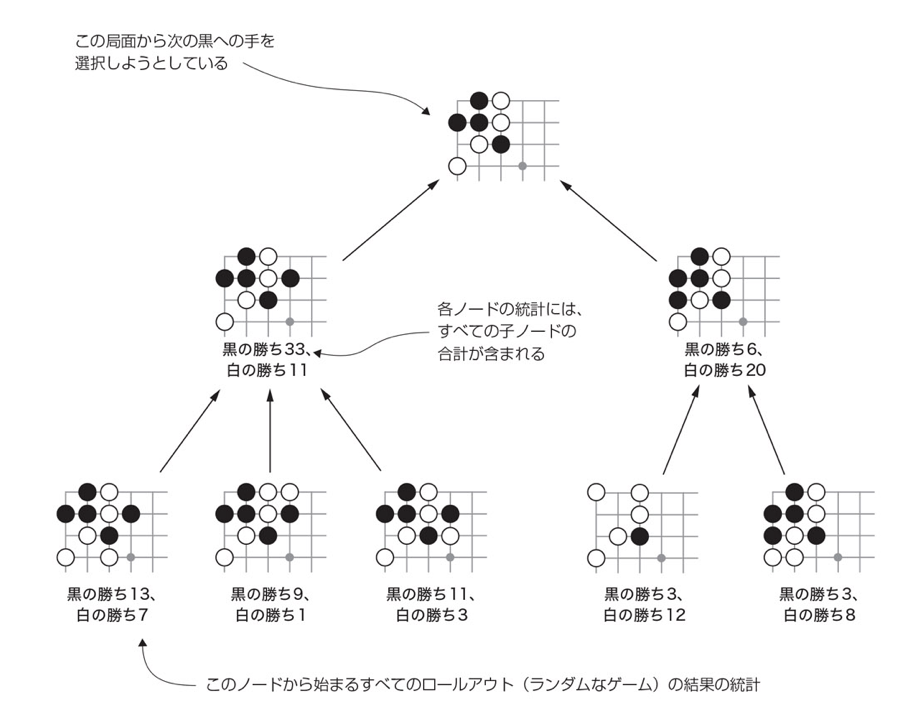

↓

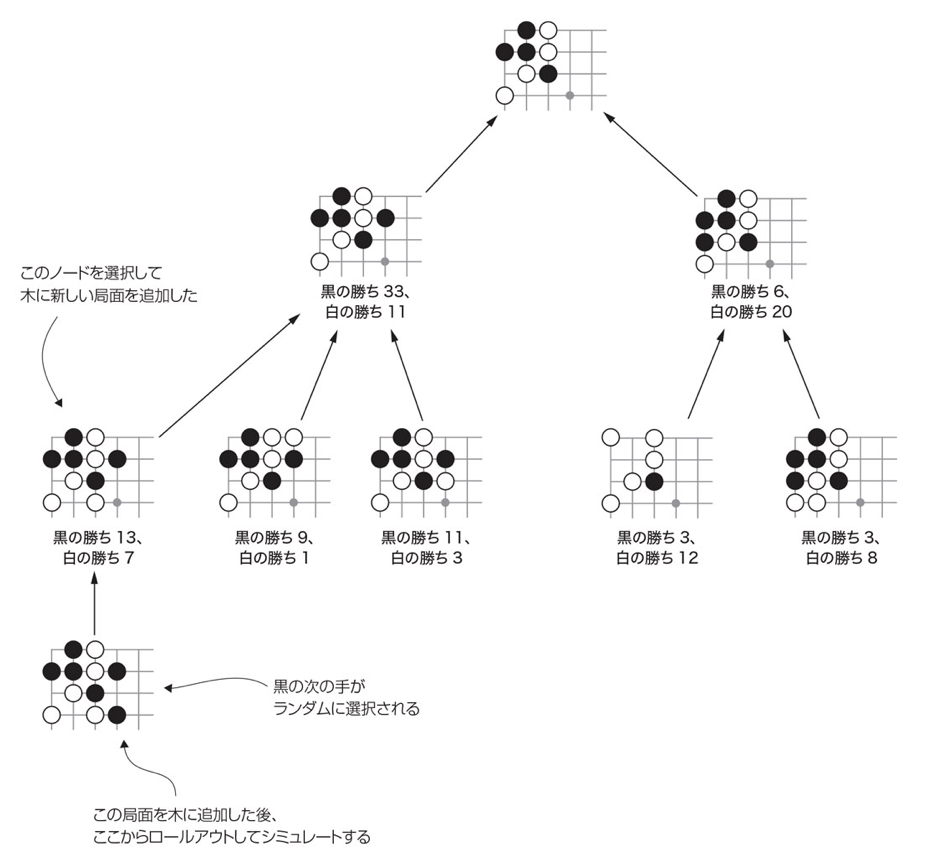

↓

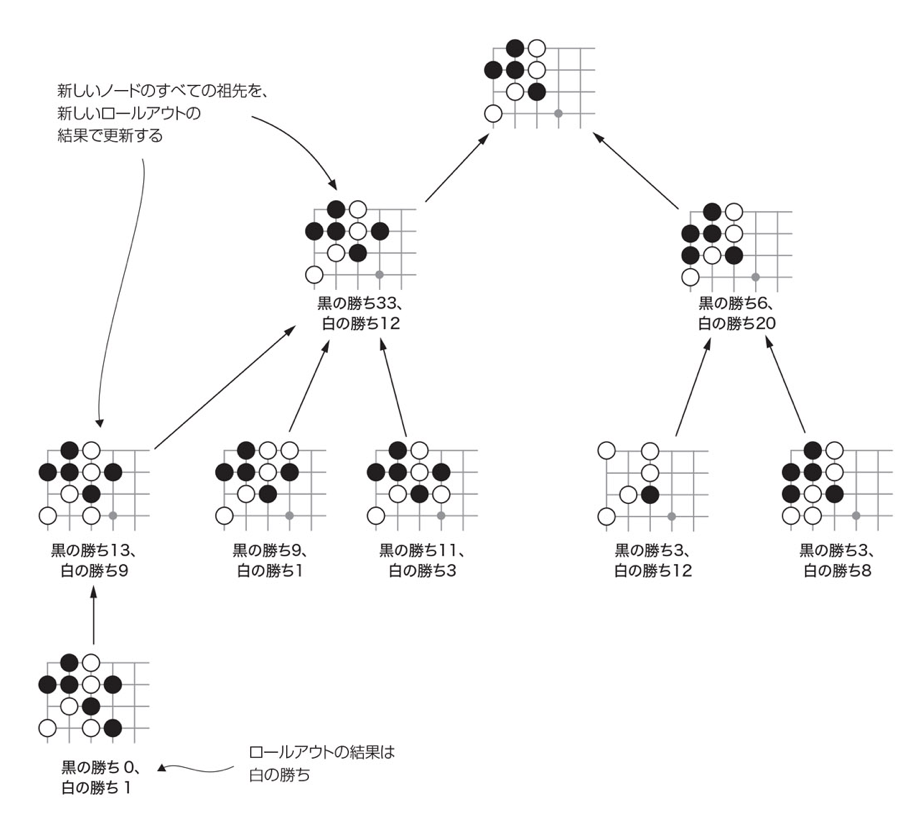

このように次の手を新しいノードとして追加しては勝ち負けの回数を数えてゆく  
この1ラウンドの処理を繰り返すことで，勝率の高い手を，全列挙することなく選ぶ  

### Pythonによるモンテカルロ木探索の実装
- MCTSアルゴリズムの木を表すデータ構造クラス MCTSNode を設計
- MCTSのロールアウトを実行する関数を実装

[コード](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/mcts/mcts.py)  
dlgo/mcts/を作成し，その中に\_\_init\_\_.pyとmcts.pyを作成．  
mcts.pyにコードを記述していく

色々足りない  
dlgo/agent/に以下を追加  
- [naive_fast.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/raw/master/code/dlgo/agent/naive_fast.py)
- [helpers_fast.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/raw/master/code/dlgo/agent/helpers_fast.py)

MCTSAgentに以下を追加

In [ ]:
def __init__(self, num_rounds, temperature):
        self.num_rounds = num_rounds
        self.temperature = temperature
...

@staticmethod
def simulate_random_game(game):
    """
    このノードからロールアウトを開始
    """
    bots = {
        Player.black: FastRandomBot(),
        Player.white: FastRandomBot(),
    }

    while not game.is_over():
        bot_move = bots[game.next_player].select_move(game)
        game = game.apply_move(bot_move)

    return game.winner()

### 探索する枝を選択する方法
各手番に費やせる時間は限られているため，どこの着手をしっかり考えるか，配分が必要  

配分を決める標準的な戦略に，upper confidence bound for trees(木のための信頼上限, UCT）がある．  
これは，2つの相反する目標に基づく，ノードのスコアを用いる戦略である．

最初の目標: 利用(exploitation)  
勝率が高い手に多くのロールアウトを割り当てていく

もう一つの目標: 探索(exploration)  
一番訪問していない枝にロールアウトを割り当て，より正確な推定値を得る

利用と探索はトレードオフになっている  
強化学習について説明する時，再び取り上げる

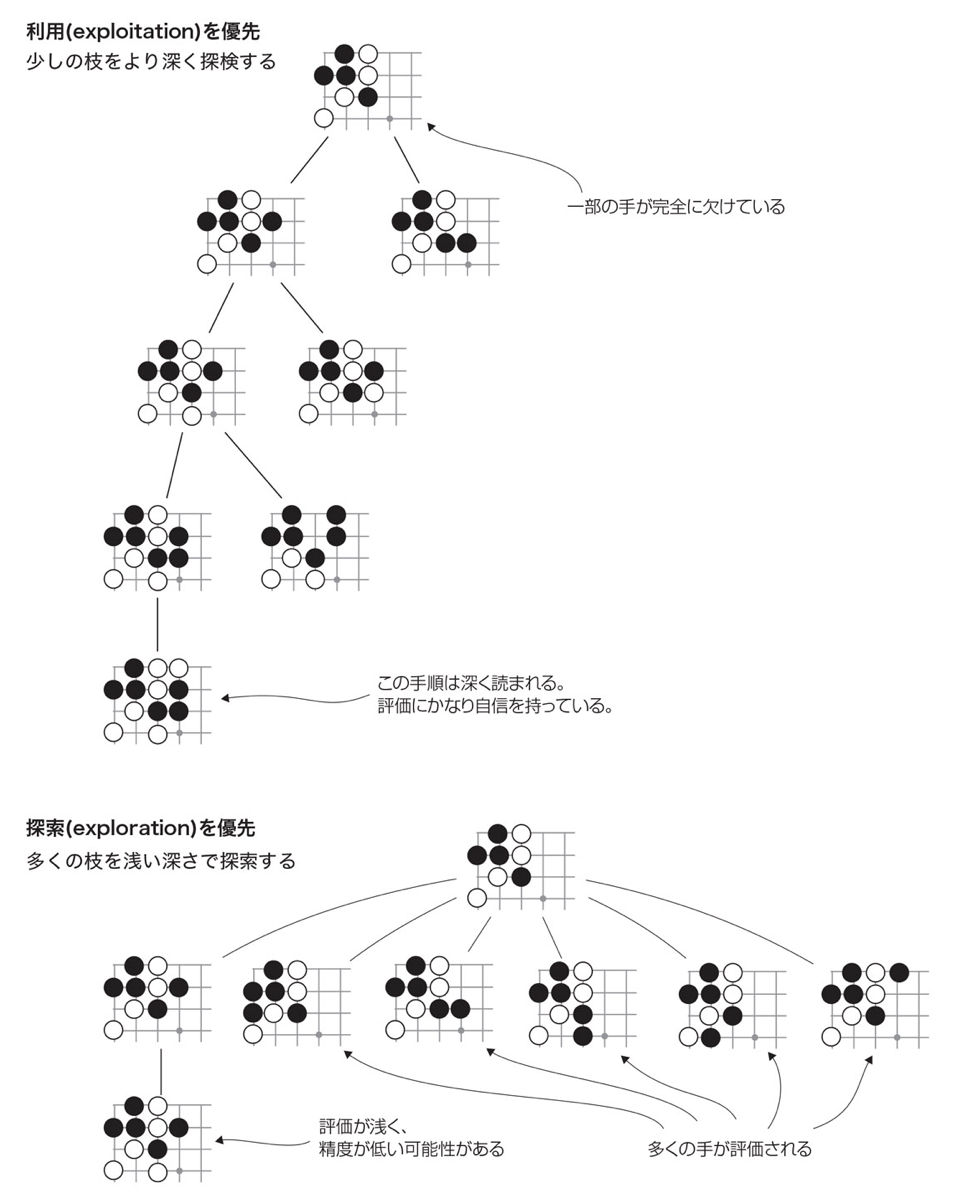

最も高い次のUCTスコアを持つノードが次のロールアウトの開始点になる
$$ UCT = w + c \sqrt{\frac{\log N}{n}} $$
第1項は利用の目標を表す勝率，第2項は探索のスコアである．  
ここで，  
- $N$: ロールアウトの総数(制限時間)
- $n$: 考慮中のノードで開始されたロールアウトの数(経過時間)
- $c$: 利用と探索の間の優先度のバランスを表すパラメータ
    - 温度とも呼ばれ，1.5あたりから始めて，試行錯誤で求める  

つまり，探索時間が経過するほど，利用を優先するようになっていく  
ルートとか対数がついているのは大きさのスケールをなるべく$w$に合わせるため？

気になってlogの意味を調べてみた  
https://atarimae.biz/archives/12731  
自然対数をとるのは，微分を行う可能性がある時．  
$$ (log_e x )' = \frac{1}{x} $$
常用対数をとるのは，生物学など，ものの大きさのスケールを見やすくする時  
二進対数をとるのは，情報理論などが背景にある時

uct_scoreとselect_childを実装する

### モンテカルロ木探索を以後に適用するための実践的考察
MCTSのナイーブな実装だけでも，アマチュア1段レベルになる  
今日では，MCTSと深層学習の両方を使用している．  
以下では，いくつかの実践的な詳細について説明する

#### 速いコードは強いボットを作る
フルサイズの囲碁では約10000回の手番を計算するため，高速化が必要  
短時間に多くのロールアウトを実行できるほど強くなることになる  
したがって，石の取りに関する実装など，あらゆるコードは最適化の対象となる

#### より良いロールアウトの方策はより良い評価をする
ロールアウト中に手を選択するアルゴリズムはロールアウトポリシーと呼ばれる  
つまり，ロールアウト中にどんなボットを使うか，ということである  
  
ここで使用したようなRandomBotのようなものは軽いロールアウトと呼ばれる  
一方，ゲーム固有のロジックを備えたロールアウトは重いロールアウトと呼ばれる    
ロールアウトが重いと，ロールアウトを多くは実行できなくなるので，注意する  
  
ロールアウトポリシーには，次のオープンソース囲碁エンジンが参考になる  
- [Fuego](fuego.sourceforge.net/)
- [Pachi](github.com/pasky/pachi)

#### 礼儀正しいボットは投了する時を知っている
プレイヤーが明らかに優勢な時には，ボットには潔く投了してほしい  
MCTSの過程では推定勝率を計算する．  
これが例えば10%以下になった時投了させるということができる